In [98]:
import random
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Set constraints
## Land boundry

In [99]:
min_house_width = 6
max_house_width = 18

min_house_depth = 8
max_house_depth = 25

# house_width = random.randint(min_house_width, max_house_width)
# house_depth = random.randint(min_house_depth, max_house_depth)

# set manually for now
house_width = 10
house_depth = 15

boundary = Polygon([(0, 0), (house_width, 0), (house_width, house_depth), (0, house_depth)])

## Rooms size range

In [100]:
# Define room types (type, min_width, max_width, min_depth, max_depth)
rooms_range = [
    ("LR", 3, 6, 3, 6),     #Living Room     
    ("MBR", 3, 6, 3, 6),    #Master Bedroom
    ("BR", 3, 4.5, 3, 4.5), #Bedroom
    # ("BR2", 3, 4.5, 3, 4.5),       #Bedroom2
    ("KIC", 2, 4, 2, 4),    #Kitchen     
    ("BA", 2, 4, 2, 5),     #Bathroom
    ("HW", 1, 1.5, 2, 10),  #Hallway
    ("BAL", 1, 2, 2, 8),    #Balcony
    ("DR", 3, 5, 3, 5),  #Dining Room
]

## Components size range
**window & door**

In [101]:
min_window_width = 0.5
max_window_width = 1.5

min_door_width = 0.5
max_door_width = 1.5


# Room class

In [102]:
class Room:
    def __init__(self, name, width, depth, x, y):
        self.name = name
        self.width = width
        self.depth = depth
        self.x = x
        self.y = y

    def get_polygon(self):
        return Polygon([(self.x, self.y), (self.x + self.width, self.y), (self.x + self.width, self.y + self.depth), (self.x, self.y + self.depth)])
    
    def __str__(self):
        return f"{self.name} width: {self.width}, depth: {self.depth} at ({self.x}, {self.y})"

# House class

In [103]:
class House:
    def __init__(self, rooms, boundary):
        self.rooms = rooms
        self.cluster = self.get_cluster()
        self.boundary = boundary

    # combine rooms into a cluster polygon
    def get_cluster(self):
        cluster = Polygon()
        for room in self.rooms:
            cluster = cluster.union(room.get_polygon())
        return cluster

# Feasibility check Function(s)

In [104]:
def is_valid_placement(rect, cluster, boundary):
    # check if the rectangle is within the house land
    if not boundary.contains(rect):
        return False
    
    # check if the rectangle attaches to the cluster, neither overlap nor separate
    if cluster is None:
        return True
    elif cluster.touches(rect):
        touch_part = cluster.intersection(rect)
        # not just a point touching
        if touch_part.geom_type in ["LineString", "MultiLineString"]:
            return True
        else:
            return False
    else:
        return False

# Generate!

In [105]:
def generate_house(boundary, rooms_range):
    placed_rooms = []
    cluster = None

    for room_type, min_width, max_width, min_depth, max_depth in rooms_range:
        placed = False
        iteration_times = 0

        while not placed and iteration_times < 1000:    
            width = round(random.uniform(min_width, max_width)/granularity_size) * granularity_size
            depth = round(random.uniform(min_depth, max_depth)/granularity_size) * granularity_size
            
            if not placed_rooms:
                # place the first room
                x = round(random.uniform(0, house_width - width)/granularity_size) * granularity_size
                y = round(random.uniform(0, house_depth - depth)/granularity_size) * granularity_size
            else:
                # Add new room adjacent to an existing room
                base_room = random.choice(placed_rooms)
                bottom_left = base_room.x, base_room.y
                bottom_right = base_room.x + base_room.width, base_room.y
                top_right = base_room.x + base_room.width, base_room.y + base_room.depth
                top_left = base_room.x, base_room.y + base_room.depth

                direction = random.choice(["left", "right", "up", "down"])
                if direction == "left":
                    # top or bottom
                    random_int = random.randint(0, 1)
                    if random_int == 0:
                        x = bottom_left[0] - width
                        y = bottom_left[1]
                    else:
                        x = top_left[0] - width
                        y = top_left[1] - depth
                elif direction == "right":
                    # top or bottom
                    random_int = random.randint(0, 1)
                    if random_int == 0:
                        x = bottom_right[0]
                        y = bottom_right[1]
                    else:
                        x = top_right[0]
                        y = top_right[1] - depth
                elif direction == "up":
                    # left or right
                    random_int = random.randint(0, 1)
                    if random_int == 0:
                        x = top_left[0]
                        y = top_left[1]
                    else:
                        x = top_right[0] - width
                        y = top_right[1]
                elif direction == "down":
                    # left or right
                    random_int = random.randint(0, 1)
                    if random_int == 0:
                        x = bottom_left[0]
                        y = bottom_left[1] - depth
                    else:
                        x = bottom_right[0] - width
                        y = bottom_right[1] - depth
                    
            new_room = Room(room_type, width, depth, x, y)

            if is_valid_placement(new_room.get_polygon(), cluster, boundary):
                placed_rooms.append(new_room)
                if cluster is None:
                    cluster = new_room.get_polygon()
                else:
                    cluster = cluster.union(new_room.get_polygon())
                placed = True
            iteration_times += 1
        if not placed:
            print(f"Failed to place {room_type} after 1000 iterations")
                
            
    return placed_rooms, cluster

# Fitness of previous Evaluation indicators

## 1. dis (MBR, BR) +

In [106]:
# calculate the distance between the center of the master bedroom and bedroom
# normalize the distance
def dis_MBR_BR(house):
    MBR = None
    BR = None
    for room in house.rooms:
        if room.name == "MBR":
            MBR = room
        if room.name == "BR":
            BR = room
    if MBR is None or BR is None:
        return 0
    mbr_center = (MBR.x + MBR.width/2, MBR.y + MBR.depth/2)
    br_center = (BR.x + BR.width/2, BR.y + BR.depth/2)
    min_dis = min(MBR.width + BR.width, MBR.depth + BR.depth)
    # diagonal distance is the possible max distance between two points
    max_dis = (boundary.bounds[2]**2 + boundary.bounds[3]**2)**0.5
    distance = ((mbr_center[0] - br_center[0])**2 + (mbr_center[1] - br_center[1])**2)**0.5

    normalized_distance = (distance - min_dis) / (max_dis - min_dis)

    return normalized_distance

## 2. dis (MBR, BA) +

In [107]:
# calculate the distance between the center of the master bedroom and bathroom
# normalize it
def dis_MBR_BA(house):
    MBR = None
    BA = None
    for room in house.rooms:
        if room.name == "MBR":
            MBR = room
        if room.name == "BA":
            BA = room
    if MBR is None or BA is None:
        return 0
    mbr_center = (MBR.x + MBR.width/2, MBR.y + MBR.depth/2)
    ba_center = (BA.x + BA.width/2, BA.y + BA.depth/2)
    min_dis = min(MBR.width + BA.width, MBR.depth + BA.depth)
    max_dis = (boundary.bounds[2]**2 + boundary.bounds[3]**2)**0.5
    distance = ((mbr_center[0] - ba_center[0])**2 + (mbr_center[1] - ba_center[1])**2)**0.5

    normalized_distance = (distance - min_dis) / (max_dis - min_dis)

    return normalized_distance

## 3. Orientation of LR +
(0: north; 1: south) , 1 is preferred (in Northern hemisphere)

In [108]:
# check the orientation of living room
def check_LR_orientation(house):
    LR = None
    for room in house.rooms:
        if room.name == "LR":
            LR = room
    if LR is None:
        return 0
    
    min_y_cluster = house.cluster.bounds[1]
    min_y_LV = LR.get_polygon().bounds[1]

    if min_y_LV <= min_y_cluster:
        return 1
    else:
        return 0


## 5. Ventilation +
(Ratio of width to depth of floor plan)  
to be maximized

In [109]:
# Calculate the Ration of width to depth of the whole house
def width_depth_ratio(house):
    house_width = house.cluster.bounds[2]
    house_depth = house.cluster.bounds[3]

    min_ratio = 0.2
    max_ratio = 5.0

    ratio = house_width / house_depth
    normalized_ratio = (ratio - min_ratio) / (max_ratio - min_ratio)

    return normalized_ratio

## 7. % of hall -

In [110]:
# Calculate the % of hallway area in the interior_area
def percentage_hall(house):
    hall_area = 0
    interior_area = 0
    for room in house.rooms:
        if room.name == "HW":
            hall_area += room.width * room.depth
        elif room.name != "BAL":
            interior_area += room.width * room.depth

    per_hall = hall_area / interior_area if interior_area != 0 else 0

    return 1 - per_hall

## 8. % of balcony +

In [111]:
# Calculate the % of balcony area in the interior_area
def percentage_balcony(house):
    balcony_area = 0
    interior_area = 0
    for room in house.rooms:
        if room.name == "BAL":
            balcony_area += room.width * room.depth
        elif room.name != "BAL":
            interior_area += room.width * room.depth

    per_balcony = balcony_area / interior_area if interior_area != 0 else 0

    return per_balcony

## 9. Efficiency rate of the house +

In [112]:
# the percentage of interior area to the total area
def percentage_interior(house):
    interior_area = 0
    total_area = house.cluster.area
    for room in house.rooms:
        if room.name != "BAL":
            interior_area += room.width * room.depth

    per_interior = interior_area / total_area

    return per_interior

## //10. DIS (BR, BA) -

# ▶︎Fitness calculation
- overlap penalty  
- space usage rate

In [ ]:
def fitness_function(house):
    # Evaluate both continuous (room sizes) and discrete (room positions) variables
    rooms = house.rooms
    boundary_area = house.boundary.area
    cluster_area = house.cluster.area

    # -1. normalized overlap rate -
    all_rooms_area = sum(room.width * room.depth for room in rooms)
    overlap_rate = (all_rooms_area - cluster_area) / boundary_area
    # print(overlap_rate)

    # -2. space usage rate +
    # print("Boundray area: ", boundary_area)
    space_usage_rate = cluster_area / boundary_area
    # print(space_usage_rate)

    # 1. distance between MBR and BR
    # fit_1 = dis_MBR_BR(house)
    
    return (1 - overlap_rate) + space_usage_rate + dis_MBR_BR(house) + dis_MBR_BA(house) + check_LR_orientation(house) + width_depth_ratio(house) + percentage_hall(house) 

# print(fitness_function(house_example))

# * Parameters

In [114]:
granularity_size = 0.5
granularity_position = 0.5

pso_iter = 200
particle_num = 50
mcts_iter = 150


# Draw house function

In [115]:
def draw_house_cluster(house, fitness):
    rooms = house.rooms
    boundary = house.boundary
    plt.figure(figsize=(10, 6)) 
    x, y = boundary.exterior.xy
    plt.plot(x, y, color="black")
    plt.fill(x, y, color='grey', alpha=0.1)
    for i, room in enumerate(rooms):
        room_polygon = room.get_polygon()
        x, y = room_polygon.exterior.xy
        plt.fill(x, y, alpha=0.8)
        plt.plot(x, y, alpha=0.9)
        plt.text(room_polygon.centroid.x, room_polygon.centroid.y, room.name, ha="center", va="center")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.grid(True, linestyle='--', alpha=0.1)
    plt.title(f"Fitness: {fitness}")
    plt.show()

# Display the result

LR width: 3.5, depth: 3.0 at (2.5, 4.0)
MBR width: 4.0, depth: 5.5 at (6.0, 1.5)
BR width: 4.5, depth: 3.5 at (1.5, 7.0)
KIC width: 2.0, depth: 2.5 at (6.0, 7.0)
BA width: 3.5, depth: 3.5 at (6.0, 9.5)
HW width: 1.0, depth: 2.5 at (5.0, 10.5)
BAL width: 1.5, depth: 5.5 at (1.0, 1.5)
DR width: 4.5, depth: 3.5 at (0.5, 10.5)


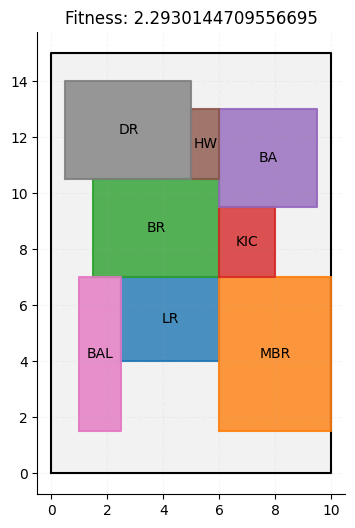

In [116]:
rooms_example, cluster = generate_house(boundary, rooms_range)
house_example = House(rooms_example, boundary)
for room in rooms_example:
    print(room)

fitness = fitness_function(house_example)
draw_house_cluster(house_example, fitness)

# Function to Save Snapshots

In [117]:
import os

# Function to save snapshots
def save_snapshots(starting_time, current_layout, iteration_count, fitness):
    plt.figure(figsize=(10, 6)) 
    x, y = current_layout.boundary.exterior.xy
    plt.plot(x, y, color="black")
    plt.fill(x, y, color='grey', alpha=0.1)
    for i, room in enumerate(current_layout.rooms):
        room_polygon = room.get_polygon()
        x, y = room_polygon.exterior.xy
        plt.fill(x, y, alpha=0.8)
        plt.plot(x, y, alpha=0.9)
        plt.text(room_polygon.centroid.x, room_polygon.centroid.y, room.name, ha="center", va="center")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.grid(True, linestyle='--', alpha=0.1)
    plt.title(f"Fitness: {fitness}")
    # create target folder if not exists
    if not os.path.exists(f"results/{starting_time}"):
        os.makedirs(f"results/{starting_time}")
    plt.savefig(f"results/{starting_time}/{iteration_count}.png")
        
    plt.close()

# PSO-MCTS
## PSO

In [118]:
import math
import random
import numpy as np
from datetime import datetime
from collections import defaultdict

from shapely import Point

class PSO:
    def __init__(self, rooms_range, num_particles, max_iter):
        self.rooms_range = rooms_range
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.gbest_fitness = -float('inf')
        self.gbest_sizes = []
        self.gbest_layout = None
        
        # Initialize particles
        self.particles = []
        for _ in range(num_particles):
            particle = {
                'sizes': [self.random_size(room) for room in rooms_range],
                'velocity': [[0, 0] for _ in rooms_range],
                'pbest_fitness': -float('inf'),
                'pbest_sizes': []
            }
            self.particles.append(particle)

    def random_size(self, room):
        min_w, max_w, min_d, max_d = room[1:]
        return [
            round(random.uniform(min_w, max_w) / granularity_size) * granularity_size,
            round(random.uniform(min_d, max_d) / granularity_size) * granularity_size
        ]

    def optimize(self, boundary):
        current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
        for _ in range(self.max_iter):
            for particle in self.particles:
                # Evaluate fitness using MCTS
                rooms = []
                for i, size in enumerate(particle['sizes']):
                    rooms.append((self.rooms_range[i][0], size[0], size[1]))
                
                mcts = MCTS(boundary, rooms)
                best_layout = mcts.search()
                # print("Best layout:", len(best_layout.rooms))
                fitness = fitness_function(best_layout)
                
                # Update personal best
                if fitness > particle['pbest_fitness']:
                    particle['pbest_fitness'] = fitness
                    particle['pbest_sizes'] = particle['sizes'].copy()
                
                # Update global best
                if fitness > self.gbest_fitness:
                    self.gbest_fitness = fitness
                    self.gbest_sizes = particle['sizes'].copy()
                    self.gbest_layout = best_layout
            
            # Update velocities and positions
            for particle in self.particles:
                for i in range(len(particle['sizes'])):
                    w = 0.5  # inertia
                    c1 = 0.6    # cognitive
                    c2 = 0.9    # social
                    
                    v = [
                        w * particle['velocity'][i][0] + \
                        c1 * random.random() * (particle['pbest_sizes'][i][0] - particle['sizes'][i][0]) + \
                        c2 * random.random() * (self.gbest_sizes[i][0] - particle['sizes'][i][0]),
                        w * particle['velocity'][i][1] + \
                        c1 * random.random() * (particle['pbest_sizes'][i][1] - particle['sizes'][i][1]) + \
                        c2 * random.random() * (self.gbest_sizes[i][1] - particle['sizes'][i][1])
                    ]
                    
                    particle['velocity'][i] = v
                    particle['sizes'][i] = [
                        max(min(round((particle['sizes'][i][0] + v[0])/granularity_size)*granularity_size, self.rooms_range[i][2]), self.rooms_range[i][1]),
                        max(min(round((particle['sizes'][i][1] + v[1])/granularity_size)*granularity_size, self.rooms_range[i][4]), self.rooms_range[i][3])
                    ]

            # Save snapshots, the initial, final and every 25 iterations
            if _ == 0 or _ == self.max_iter - 1 or _ % 25 == 0:
                # force the count number to be like: 0001, 0002, 0003, ...
                save_snapshots(current_time, self.gbest_layout, str(_).zfill(4), self.gbest_fitness)
        
        return self.gbest_layout

## MCTS

### MCTS Node

In [119]:
class MCTSNode:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = []
        self.visits = 0
        self.value = 0
        self.untried_actions = state.get_legal_actions()

### LayoutState

### MCTS algorithm

In [120]:
class MCTS:
    def __init__(self, boundary, rooms, iterations=mcts_iter, exploration=1.414):
        self.boundary = boundary
        self.rooms = rooms
        self.iterations = iterations
        self.exploration = exploration

    def search(self):
        root_state = LayoutState(self.boundary, self.rooms)
        root_node = MCTSNode(root_state)
        best_reward = -float('inf')
        best_state = None
        
        for _ in range(self.iterations):
            node = root_node
            state = root_state.copy()
            valid_simulation = True
            
            # Selection with validity check
            while node.untried_actions == [] and node.children != []:
                # print("Selecting child")
                node = self.select_child(node)
                if not state.place_room(node.action):
                    valid_simulation = False
                    break
            
            if not valid_simulation:
                continue  # Skip invalid paths 

            # Expansion with smart action selection 
            if node.untried_actions:
                action = random.choice(node.untried_actions)
                # print("Expanding with action")
                if state.place_room(action):
                    node.untried_actions.remove(action)
                    new_node = MCTSNode(state.copy(), node, action)
                    node.children.append(new_node)
                    node = new_node
            
            # Enhanced simulation with retry mechanism 
            simulation_state = state.copy()
            max_attempts = 100
            attempts = 0
            while not simulation_state.all_placed() and attempts < max_attempts:
                legal_actions = simulation_state.get_legal_actions()
                if not legal_actions:
                    valid_simulation = False
                    break
                action = random.choice(legal_actions)
                if not simulation_state.place_room(action):
                    valid_simulation = False
                    break
                # print("Correct place?:", simulation_state.place_room(action))

                attempts += 1

            # Reward calculation 
            if not valid_simulation:
                reward = 0.0
            elif simulation_state.all_placed():
                reward = fitness_function(simulation_state.get_house())
                if reward > best_reward:
                    best_reward = reward
                    best_state = simulation_state
            
            # Backpropagation
            current_node = node
            while current_node is not None:
                current_node.visits += 1
                current_node.value += reward
                current_node = current_node.parent
        
        # print("Reward:", reward)
        # # print("node.visits:", root_node.visits)
        # print("node.children:", len(root_node.children))
        # # print("node.action:", node.action)
        # return self.get_best_layout(root_node.children)
        if best_state:
            return best_state.get_house()
        else:
            return self.get_best_layout(root_node.children)
    
    def select_child(self, node):
        log_total = math.log(node.visits)
        best_score = -float('inf')
        best_child = None
        
        for child in node.children:
            score = child.value / child.visits + self.exploration * math.sqrt(log_total / child.visits)
            if score > best_score:
                best_score = score
                best_child = child
        
        return best_child
    
    def get_best_layout(self, children):
        best_value = -float('inf')
        best_node = None
        for child in children:
            if child.visits > best_value:
                best_value = child.visits
                best_node = child
        return best_node.state.get_house()

In [121]:
class LayoutState:
    def __init__(self, boundary, rooms):
        self.boundary = boundary
        self.rooms = rooms
        self.current_room = 0
        self.placed_rooms = []
        self.cluster = None

    def copy(self):
        """Create a deep copy of the state."""
        new_state = LayoutState(self.boundary, self.rooms)
        new_state.current_room = self.current_room
        new_state.placed_rooms = self.placed_rooms.copy()
        new_state.cluster = self.cluster
        return new_state
    
    def get_legal_actions(self):
        if self.current_room >= len(self.rooms):
            return []
        
        room_type, width, depth = self.rooms[self.current_room]
        legal_positions = []
        for x in np.arange(0, self.boundary.bounds[2]-width, granularity_position):
                for y in np.arange(0, self.boundary.bounds[3]-depth, granularity_position):
                    legal_positions.append((x, y))
        # # if cluster is None, all positions are legal
        # if self.cluster is None:
        #     for x in np.arange(0, self.boundary.bounds[2]-width, granularity):
        #         for y in np.arange(0, self.boundary.bounds[3]-depth, granularity):
        #             legal_positions.append((x, y))
        # # if cluster is not None, only positions that not in the cluster are legal
        # else:
        #     for x in np.arange(0, self.boundary.bounds[2]-width, granularity):
        #         for y in np.arange(0, self.boundary.bounds[3]-depth, granularity):
        #             if not Point(x, y).within(self.cluster):
        #                 legal_positions.append((x, y))

        return legal_positions

    def place_room(self, position):
        x, y = position
        room_type, width, depth = self.rooms[self.current_room]
        new_room = Room(room_type, width, depth, x, y)
        
        # Add buffer to handle geometric issues 💡
        try:
            new_poly = new_room.get_polygon().buffer(0)
            if self.cluster:
                combined = self.cluster.buffer(0).union(new_poly)
                if not combined.is_valid:
                    return False
                self.cluster = combined
            else:
                self.cluster = new_poly
            
            self.placed_rooms.append(new_room)
            # print("Placed room:", len(self.placed_rooms))
            self.current_room += 1
            # print("Current room:", self.current_room)
            return True
        except:
            return False
        
    def all_placed(self):
        """Check if all rooms have been placed."""
        return self.current_room >= len(self.rooms)
    
    def get_house(self):
        """Create a House object from the current state."""
        # print("Placed--rooms:", len(self.placed_rooms))
        return House(self.placed_rooms, self.boundary)

# Run PSO-MCTS

In [ ]:
# Modified generate_house function using PSO-MCTS
def generate_house_pso_mcts(boundary, rooms_range, pso_iter=pso_iter):
    # Optimize room sizes with PSO
    pso = PSO(rooms_range, num_particles=particle_num, max_iter=pso_iter)
    best_house = pso.optimize(boundary)
    # print rooms (name, width, depth, x, y)
    for room in best_house.rooms:
        print(room)


    # final check
    if len(best_house.rooms) < len(rooms_range):
        print("Failed to place all rooms")
    
    return best_house

# Run the PSO-MCTS algorithm
house_example = generate_house_pso_mcts(boundary, rooms_range)

if house_example.cluster.is_valid:
    # print(f"Fitness: {fitness_function(house_example):.2f}")
    fitness = fitness_function(house_example)
else:
    print("Generated invalid layout")

draw_house_cluster(house_example, fitness)

MultiPolygon


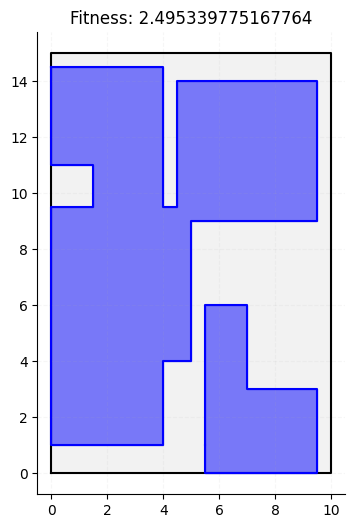

In [ ]:
print(house_example.cluster.geom_type)
# draw this cluster
plt.figure(figsize=(10, 6))
x, y = house_example.boundary.exterior.xy
plt.plot(x, y, color="black")
plt.fill(x, y, color='grey', alpha=0.1)

if house_example.cluster.geom_type == 'MultiPolygon':
	for poly in house_example.cluster.geoms:
		x, y = poly.exterior.xy
		plt.plot(x, y, color="blue")
		plt.fill(x, y, color='blue', alpha=0.5)
else:
	x, y = house_example.cluster.exterior.xy
	plt.plot(x, y, color="blue")
	plt.fill(x, y, color='blue', alpha=0.5)
	# minus the inner part from the exterior
	for poly in house_example.cluster.interiors:
		x_i, y_i = poly.xy
		plt.fill(x_i, y_i, color='white')

plt.gca().set_aspect("equal", adjustable="box")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.grid(True, linestyle='--', alpha=0.1)
plt.title(f"Fitness: {fitness}")
plt.show()